# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

Logic: The idea is to generate profitable portfolios while controlling risk, and after translating into mathematical terminology, the end goal would be creating portfolios with high expected return while controlling their volatilities. For the first portfolio (the one with higher risk), we could aim for higher expected return but with high volatility. The usual benchmark of high return is chosen to be SP500 (^GSPC). Because higher volatility is acceptable, we could aim for incorporating more large-cap growth stocks in this portfolio, by using ETFs like IWY and QQQ. For the second portfolio where we want moderate return (still greater or equal to the annual of SP500) but less volatility, and ways to realize it might include including more defensive stocks from sectors like utilities and consumer staples, and further diversify by adding assets like gold. I would build those two portfolios primarily using ETFs as they provide sufficient diversification, under the constraint that both portfolios must have 1-year returns higher than that of the SP500 (10.26%) while minimizing the annualized volatility once the assets were chosen under additional constraints that one cannot invest more than 35% of capital into a single index. For this project, we assume static portfolio.

In [1]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
%run functions.py

c:\Users\yqing\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


High-risk portfolio:
Below we construct the higher-risk portfolio; the list of ETFs we pick is given below with rationale:

Invesco QQQ Trust (QQQ): Tracks NASDAQ-100 for tech growth exposure.

VanEck Semiconductor ETF (SMH): Captures semiconductor boom in AI.

iShares Russell Top 200 Growth ETF (IWY): Diversifies large-cap growth.

Vanguard S&P 500 ETF (VOO): Provides broad market stability.

Financial Select Sector SPDR Fund (XLF): Leverages high-rate financials.

Invesco Galaxy Bitcoin ETF (BTCO): Adds speculative crypto growth.

Global X Defense Tech ETF (SHLD): Targets defense tech innovation and hedges against geopolitical risk.




[*********************100%***********************]  7 of 7 completed


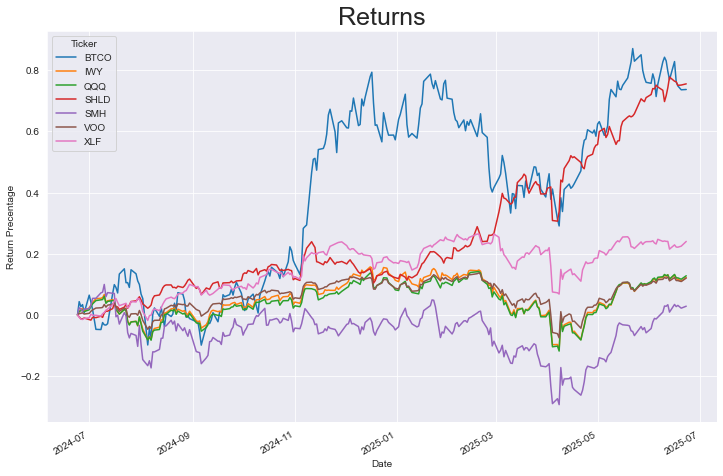

In [47]:
# Plot the cumulative returns of the following stocks over the last years

tickers = ['QQQ', 'SMH', 'IWY', 'VOO', 'XLF','BTCO','SHLD']

start_date = '2024-06-24'
end_date = '2025-06-24'

stock = yf.download(tickers, start = start_date, end = end_date)

#normalize the return first when plotting 
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

#Plot Cumlative Returns together
stock = pd.concat([stock, normalized_returns], axis =1 )
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Return Precentage')
plt.show()

In [48]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#compute and print expected returns
expected_returns = daily_returns.mean() * 252
print("Annualized Expected Returns:")
for ticker, return_val in expected_returns.items():
    print(f"{ticker}: {return_val:.4f}")


#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
annualized_volatility

Annualized Expected Returns:
BTCO: 0.5589
IWY: 0.1166
QQQ: 0.1219
SHLD: 0.5695
SMH: 0.0285
VOO: 0.1152
XLF: 0.2179


{'QQQ': 0.25413655294289805,
 'SMH': 0.4275838152121985,
 'IWY': 0.2530765051054347,
 'VOO': 0.19544495138925652,
 'XLF': 0.204418870151529,
 'BTCO': 0.5186224125254195,
 'SHLD': 0.22000874482718097}

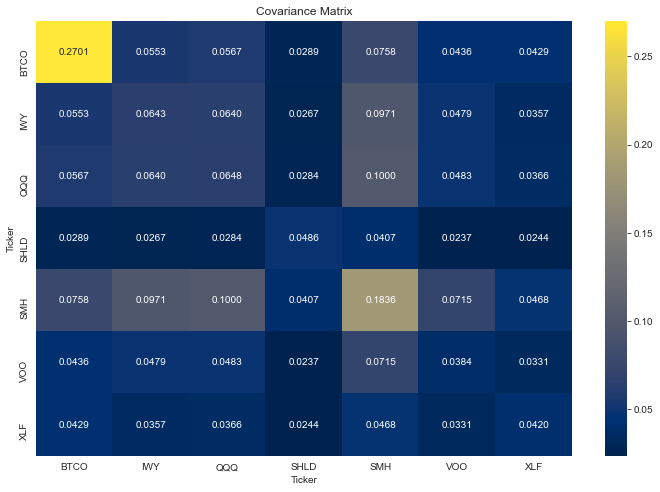

In [49]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

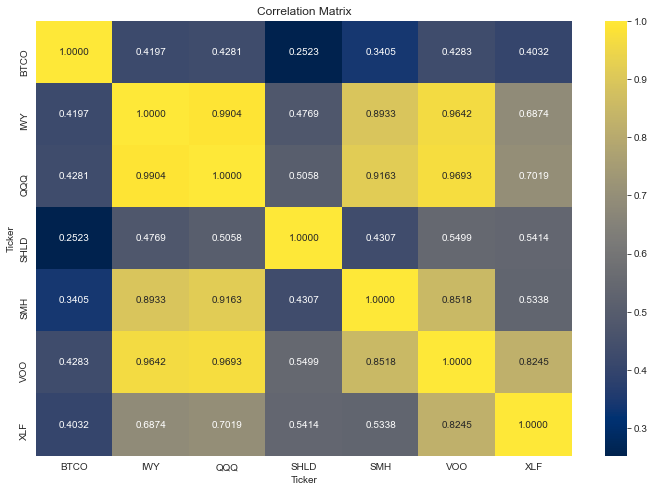

In [50]:
# Calculate the correlation matrix
correlation_matrix =  ((daily_returns).corr())

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.4f')
plt.title('Correlation Matrix')
plt.show()

One can infer from the correlation matrix that most of the assets are highly correlated to each other, which may undermine diversification attempt.

In [59]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Cannot invest more than 35% of capital into a single index
#2) Annual expected log return must be greater than 0.09767 (corresponding to linear return of 10.26% of the SP500) 

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-0.000001},
               {'type': 'ineq', 'fun': lambda weights: np.dot(weights, expected_returns) - 0.09767})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f' The optimal volatility subject to the constraints is {result.fun}')

expected_return_1 = np.dot(optimal_weights, expected_returns) 
print(f' The expected log return subject to the constraints is {expected_return_1}')

Optimal Asset Weights to minimize volatility:
QQQ: Weight = 0.0001
SMH: Weight = 0.0001
IWY: Weight = 0.0001
VOO: Weight = 0.3500
XLF: Weight = 0.0000
BTCO: Weight = 0.3500
SHLD: Weight = 0.2997
 The optimal volatility subject to the constraints is 0.17979458480099492
 The expected log return subject to the constraints is 0.30506158335927114


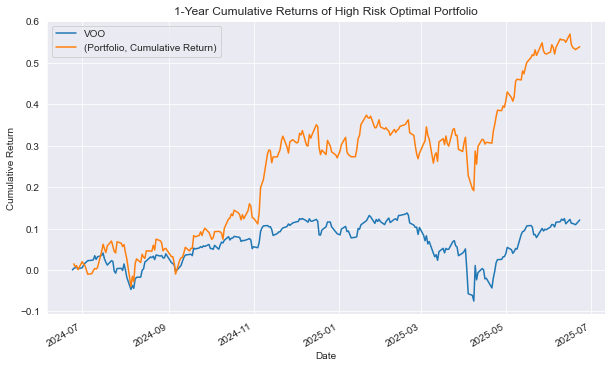

In [60]:
weight_series = pd.Series(optimal_weights, index=tickers)

#to plot the portfolio return, fist compute linearlized daily return
daily_ret = close.pct_change().dropna()
port_daily = daily_ret.dot(weight_series)
port_cum = port_daily.add(1).cumprod()-1
port_cum = pd.DataFrame(port_cum, columns=pd.MultiIndex.from_product([['Portfolio'], ['Cumulative Return']]))

voo_norm = normalized_returns['Cumulative Return']['VOO']  
# 5) Concatenate and plot
df = pd.concat([voo_norm, port_cum], axis=1)
df.plot(figsize=(10,6))
plt.title("1-Year Cumulative Returns of High Risk Optimal Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [61]:
print(port_cum.tail(1))

                   Portfolio
           Cumulative Return
Date                        
2025-06-23          0.538429


We observe that our portfolio is concentrated on VOO, SHLD and BTCO, and together the portfolio delivers much higher return (~53%) compared with SP500 (~11% using VOO as surrogate) while having less volitiality (0.1798 vs 0.1954 of the SP500).

Low-risk portfolio: Below we construct the lower-risk portfolio; the list of ETFs we pick is given below with rationale:

Invesco QQQ Trust (QQQ): Tracks NASDAQ-100 for moderate tech exposure with growth potential.

VanEck Semiconductor ETF (SMH): Provides semiconductor exposure with selective weighting for stability.

Vanguard S&P 500 ETF (VOO): Tracks S&P 500 for broad market stability.

iShares Russell Top 200 Growth ETF (IWY): Diversifies large-cap growth with lower volatility.

Invesco Aerospace & Defense ETF (PPA): Captures stable defense sector growth.

Financial Select Sector SPDR Fund (XLF): Leverages high-rate financials for steady returns.

Utilities Select Sector SPDR Fund (XLU): Offers defensive utility sector stability.

Health Care Select Sector SPDR Fund (XLV): Provides defensive healthcare exposure.

Consumer Staples Select Sector SPDR Fund (XLP): Ensures defensive consumer staples resilience.

iShares Gold Trust (IAU): Hedges inflation with low-correlation gold.

Global X Defense Tech ETF (SHLD): Targets defense tech for stable innovation-driven growth.

The ETFs we choose include more defensive sectors and hedging assets compared with the higher risk portfolio, excluded BTC to avoid exposure to high volatility of digital assets. We also require that the minimal percentage of each asset is greater or equal to 3 percent to ensure diversification of the portfolio. 

[*********************100%***********************]  11 of 11 completed


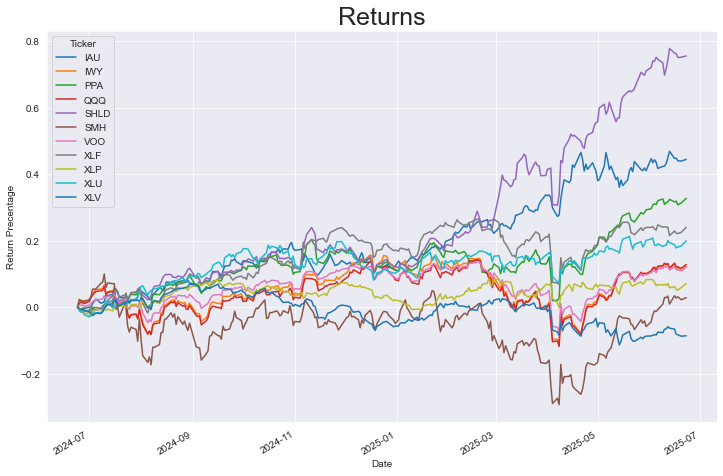

In [18]:
# Plot the cumulative returns of the following stocks over the last years

tickers = ['QQQ', 'SMH', 'IWY', 'VOO', 'XLF','SHLD','PPA','XLU','XLP','XLV','IAU']

start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

#normalize the return first when plotting 
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

#Plot Cumlative Returns together
stock = pd.concat([stock, normalized_returns], axis =1 )
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Return Precentage')
plt.show()

In [20]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#compute and print expected returns
expected_returns = daily_returns.mean() * 252
print("Annualized Expected Returns:")
for ticker, return_val in expected_returns.items():
    print(f"{ticker}: {return_val:.4f}")


#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
annualized_volatility

Annualized Expected Returns:
IAU: 0.3721
IWY: 0.1166
PPA: 0.2866
QQQ: 0.1219
SHLD: 0.5695
SMH: 0.0285
VOO: 0.1152
XLF: 0.2179
XLP: 0.0696
XLU: 0.1838
XLV: -0.0913


{'QQQ': 0.25413658158203994,
 'SMH': 0.4275838152121985,
 'IWY': 0.2530765701101378,
 'VOO': 0.1954449497948736,
 'XLF': 0.2044188508971363,
 'SHLD': 0.22000874482718097,
 'PPA': 0.20831807642163863,
 'XLU': 0.17236244585527918,
 'XLP': 0.13405208689435705,
 'XLV': 0.1608454686915169,
 'IAU': 0.17599617935423822}

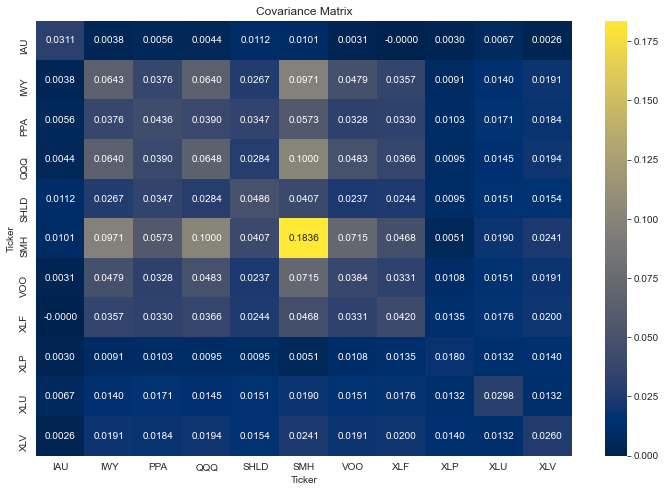

In [21]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

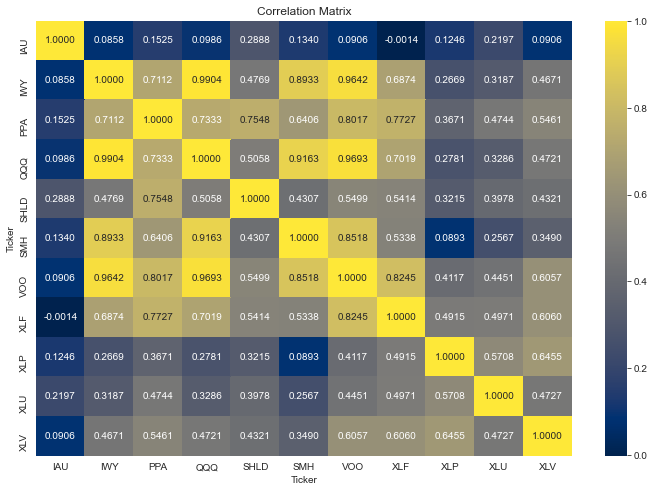

In [22]:
# Calculate the correlation matrix
correlation_matrix =  ((daily_returns).corr())

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.4f')
plt.title('Correlation Matrix')
plt.show()

One can tell from the correlation matrix that the lower risk portfolio is more diversified compared with the higher risk one.

In [39]:
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-0.03},
               {'type': 'ineq', 'fun': lambda weights: np.dot(weights, expected_returns) - 0.09767})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f' The optimal volatility subject to the constraints is {result.fun}')

expected_return_1 = np.dot(optimal_weights, expected_returns) 
print(f' The expected log return subject to the constraints is {expected_return_1}')

Optimal Asset Weights to minimize volatility:
QQQ: Weight = 0.3147
SMH: Weight = 0.0300
IWY: Weight = 0.0300
VOO: Weight = 0.0300
XLF: Weight = 0.0300
SHLD: Weight = 0.0300
PPA: Weight = 0.0300
XLU: Weight = 0.0300
XLP: Weight = 0.3500
XLV: Weight = 0.0422
IAU: Weight = 0.0832
 The optimal volatility subject to the constraints is 0.11425422587019998
 The expected log return subject to the constraints is 0.18531648521224137


Thus, the lower risk portfolio has a much lower volatility compared with the higher risk one and the drawback is that the expected log return is also lower.

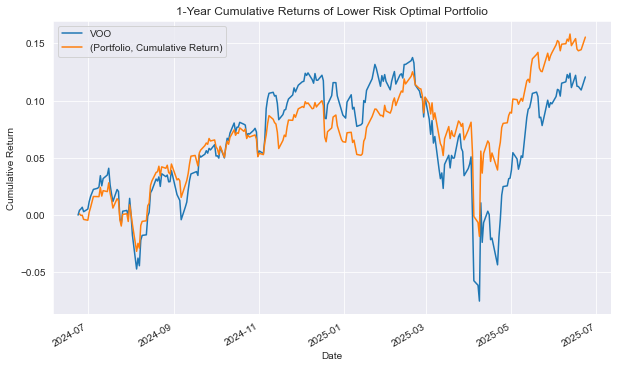

In [40]:
weight_series_l = pd.Series(optimal_weights, index=tickers)

#to plot the portfolio return, fist compute linearlized daily return
daily_ret = close.pct_change().dropna()
port_daily_l = daily_ret.dot(weight_series_l)
port_cum_l = port_daily_l.add(1).cumprod()-1
port_cum_l = pd.DataFrame(port_cum_l, columns=pd.MultiIndex.from_product([['Portfolio'], ['Cumulative Return']]))

voo_norm = normalized_returns['Cumulative Return']['VOO']  
# 5) Concatenate and plot
df = pd.concat([voo_norm, port_cum_l], axis=1)
df.plot(figsize=(10,6))
plt.title("1-Year Cumulative Returns of Lower Risk Optimal Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc='best')
plt.grid(True)
plt.show()